# Coronavirus (COVID-19) Cases, Deaths and Vaccination Data Visualisation

The purpose of this project is to practice data visualisation techniques for my personal development. 

---

The data used for this project was taken from the World Health Organization (WHO) website, which can be found at this [link](https://covid19.who.int/). The website provides access to data records that show the number of daily cases and deaths reported to the WHO globally, as well as the recorded vaccination data.

The script downloads data from the WHO website so is always displaying the most up-to-date statistics. If not internet connection, it will use the older file found in the directory.

---

In [1]:
import pandas as pd
import requests

# download data through URLs
def download_url_data(url):
    try:
        r = requests.get(url, allow_redirects=True, timeout=5)
        filename = 'data/' + url.split('/')[-1]
        open(filename, 'wb').write(r.content)
    except (requests.ConnectionError, requests.Timeout) as exception:
        print("No internet connection. Most recent file not downloaded.")
    
# read dataset
download_url_data('https://covid19.who.int/WHO-COVID-19-global-data.csv')
data = pd.read_csv('data/WHO-COVID-19-global-data.csv')

# convert 'Date_reported' column to datetime object types
data['Date_reported'] = pd.to_datetime(data['Date_reported'])

# replace negative values with 0
data._get_numeric_data()[data._get_numeric_data() < 0] = 0

# isolate UK data
data_uk = data[data['Country'] == 'The United Kingdom']
data_uk.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
158883,2020-01-03,GB,The United Kingdom,EURO,0,0,0,0
158884,2020-01-04,GB,The United Kingdom,EURO,0,0,0,0
158885,2020-01-05,GB,The United Kingdom,EURO,0,0,0,0
158886,2020-01-06,GB,The United Kingdom,EURO,0,0,0,0
158887,2020-01-07,GB,The United Kingdom,EURO,0,0,0,0


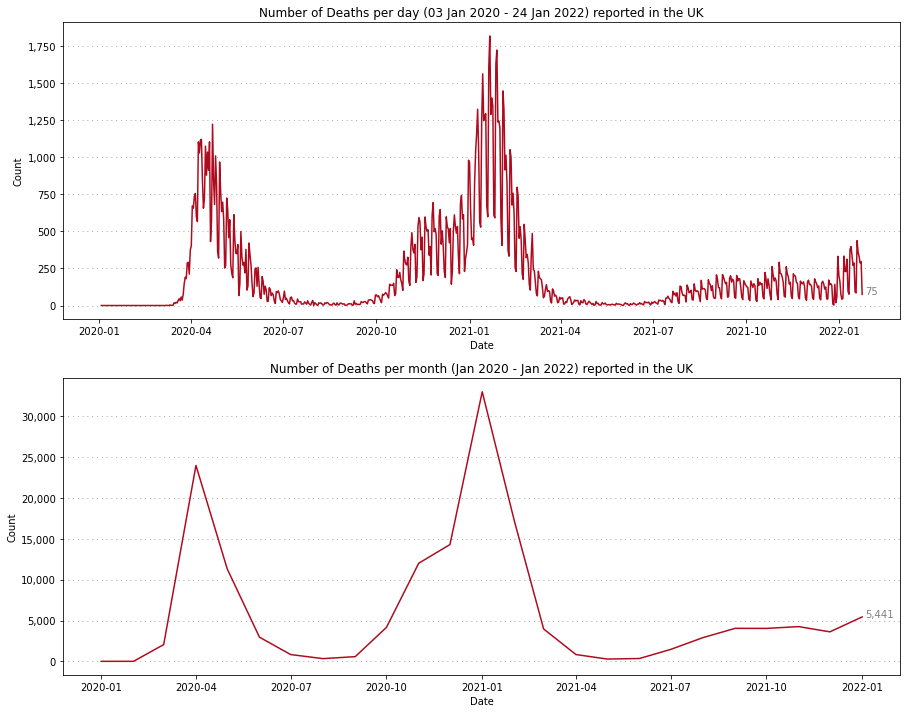

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(figsize=(15,12), nrows=2, ncols=1)
fig.set_facecolor('white')

ax1.plot(data_uk['Date_reported'], data_uk['New_deaths'], color='#af0b1e')
ax1.set(xlabel='Date', ylabel='Count')

# get the first and most recent date in dataset for uk
min_date_uk = data_uk['Date_reported'].min()
max_date_uk = data_uk['Date_reported'].max()
ax1.set_title('Number of Deaths per day (' + min_date_uk.strftime('%d %b %Y') + ' - ' + max_date_uk.strftime('%d %b %Y') + ') reported in the UK')
ax1.grid(axis='y', linestyle=':', color='grey', dashes=(1,5), zorder=0)

# most recent data sample (deaths per day plot)
most_recent_entry = data_uk[data_uk['Date_reported'] == data_uk['Date_reported'].max()]
y_co = most_recent_entry['New_deaths'].values[0]
x_co = mdates.date2num(most_recent_entry['Date_reported'])
ax1.text(x_co+3, y_co, format(y_co, ','), alpha=0.5)

# create dataframe containing the total number of cases and deaths per month
data_uk_month_total = data_uk.copy()
data_uk_month_total['Date_reported'] = data_uk_month_total['Date_reported'].dt.strftime('%Y-%m')
data_uk_month_total = data_uk_month_total.groupby('Date_reported').sum()[['New_cases', 'New_deaths']]
data_uk_month_total.reset_index(level=0, inplace=True)
data_uk_month_total['Date_reported'] = pd.to_datetime(data_uk_month_total['Date_reported'])

ax2.plot(data_uk_month_total['Date_reported'], data_uk_month_total['New_deaths'], color='#af0b1e')
ax2.set(xlabel='Date', ylabel='Count')
ax2.set_title('Number of Deaths per month (' + min_date_uk.strftime('%b %Y') + ' - ' + max_date_uk.strftime('%b %Y') + ') reported in the UK')
ax2.grid(axis='y', linestyle=':', color='grey', dashes=(1,5), zorder=0)

# most recent data sample (cases per month plot)
most_recent_entry = data_uk_month_total[data_uk_month_total['Date_reported'] == data_uk_month_total['Date_reported'].max()]
y_co = most_recent_entry['New_deaths'].values[0]
x_co = mdates.date2num(most_recent_entry['Date_reported'])
ax2.text(x_co+3, y_co, format(y_co, ','), alpha=0.5)

# format y-axis labels with ','
for ax in [ax1, ax2]:
    y_values = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_values))
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_values])

plt.show()

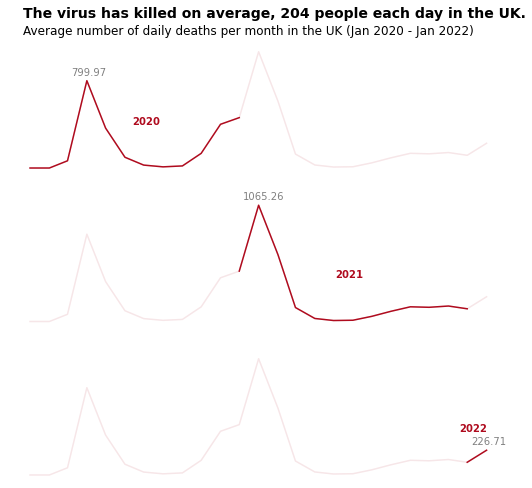

In [3]:
# create dataframe containing the average number of cases and deaths per month
data_uk_month_avg = data_uk.copy()
data_uk_month_avg['Date_reported'] = data_uk_month_avg['Date_reported'].dt.strftime('%Y-%m')
data_uk_month_avg = data_uk_month_avg.groupby('Date_reported').mean()[['New_cases', 'New_deaths']]
data_uk_month_avg.reset_index(level=0, inplace=True)
data_uk_month_avg['Date_reported'] = pd.to_datetime(data_uk_month_avg['Date_reported'])

# plot
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9,8), nrows=3, ncols=1)
fig.set_facecolor('white')
for ax in [ax1, ax2, ax3]:
    ax.plot(data_uk_month_avg['Date_reported'], data_uk_month_avg['New_deaths'], color='#af0b1e', alpha=0.1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(bottom=0, left=0) 
    for location in ['left', 'right', 'top', 'bottom']:
        ax.spines[location].set_visible(False)

# title and subtitle
uk_daily_avg_deaths = round(data_uk['New_deaths'].sum() / len(data_uk))  # calculate daily avg deaths in UK
ax1.text(18250, 1375, 'The virus has killed on average, ' + str(uk_daily_avg_deaths) + ' people each day in the UK.', size=14, weight='bold')
ax1.text(18250, 1225, 'Average number of daily deaths per month in the UK (' + min_date_uk.strftime('%b %Y') + ' - ' + max_date_uk.strftime('%b %Y') + ')', size=12)

# coordinates for each years peak (dictionary)
year_peak_coordinates = {}
for year in data_uk_month_avg['Date_reported'].dt.year.unique().tolist():
    peak = data_uk_month_avg[data_uk_month_avg['Date_reported'].dt.year == year]['New_deaths'].max()
    date = data_uk_month_avg[data_uk_month_avg['New_deaths'] == peak]['Date_reported']
    value = round(peak, 2)
    y = peak+50
    x = mdates.date2num(date)-25  # convert datetime object to number for x-coordinate
    year_peak_coordinates[year] = (x, y, value)

# plots
ax1.plot(data_uk_month_avg['Date_reported'][0:12], data_uk_month_avg['New_deaths'][0:12], color='#af0b1e')
ax1.text(18425, 400, '2020', color='#af0b1e', weight='bold')
ax1.text(year_peak_coordinates[2020][0], year_peak_coordinates[2020][1], year_peak_coordinates[2020][2], alpha=0.5)

ax2.plot(data_uk_month_avg['Date_reported'][11:24], data_uk_month_avg['New_deaths'][11:24], color='#af0b1e')
ax2.text(18750, 400, '2021', color='#af0b1e', weight='bold')
ax2.text(year_peak_coordinates[2021][0], year_peak_coordinates[2021][1], year_peak_coordinates[2021][2], alpha=0.5)

ax3.plot(data_uk_month_avg['Date_reported'][23:25], data_uk_month_avg['New_deaths'][23:25], color='#af0b1e')
ax3.text(18950, 400, '2022', color='#af0b1e', weight='bold')
ax3.text(year_peak_coordinates[2022][0], year_peak_coordinates[2022][1], year_peak_coordinates[2022][2], alpha=0.5)
plt.show()

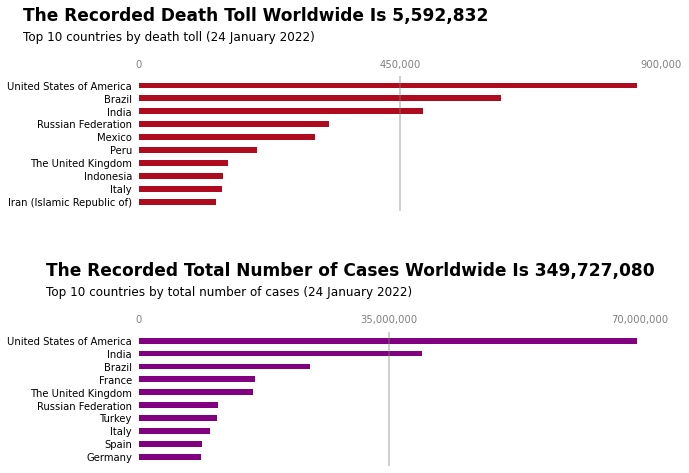

In [4]:
# top 10 countries with highest number of deaths
top_10_countries_deaths = pd.DataFrame(data.groupby('Country').sum()['New_deaths'].sort_values(ascending=False).head(10))
top_10_countries_deaths.reset_index(level=0, inplace=True)

# top 10 countries with highest number of cases
top_10_countries_cases = pd.DataFrame(data.groupby('Country').sum()['New_cases'].sort_values(ascending=False).head(10))
top_10_countries_cases.reset_index(level=0, inplace=True)

fig, (ax1, ax2) = plt.subplots(figsize=(8,6), nrows=2, ncols=1)
fig.set_facecolor('white')
fig.tight_layout(h_pad=10)
for ax in [ax1, ax2]:
    ax.xaxis.tick_top()  # move x-axis to the top
    ax.tick_params(top=False, left=False)  # remove ticks
    ax.tick_params(axis='x', colors='grey')  # change colour of xtick labels
    for location in ['left', 'right', 'top', 'bottom']:
        ax.spines[location].set_visible(False)

# plot1
ax1.barh(top_10_countries_deaths.sort_values(by='New_deaths', ascending=True)['Country'], 
        top_10_countries_deaths.sort_values(by='New_deaths', ascending=True)['New_deaths'], 
        height=0.45, color='#af0b1e')

highest_deaths_plot = round(data['Cumulative_deaths'].max(), -5)  # find highest value for x-ticks
ax1.set_xticks([0, highest_deaths_plot/2, highest_deaths_plot])  # set xtick values
ax1.set_xticklabels(['0', format(int(highest_deaths_plot/2), ','), format(int(highest_deaths_plot), ',')])  # change xtick labels to add ','
ax1.axvline(x=highest_deaths_plot/2, c='grey', alpha=0.5)  # add vertical line
world_death_toll = format(data['New_deaths'].sum(), ',')  # calculate the total death toll world-side
ax1.text(x=-200000, y=14, s='The Recorded Death Toll Worldwide Is ' + world_death_toll, weight='bold', size=17)
ax1.text(x=-200000, y=12.5, s='Top 10 countries by death toll (' + data['Date_reported'].max().strftime('%d %B %Y)'), size=12)

# plot2
ax2.barh(top_10_countries_cases.sort_values(by='New_cases', ascending=True)['Country'], 
         top_10_countries_cases.sort_values(by='New_cases', ascending=True)['New_cases'], 
         height=0.45, color='purple')

highest_cases_plot = round(data['Cumulative_cases'].max(), -6)  # find highest value for x-ticks
ax2.set_xticks([0, highest_cases_plot/2, highest_cases_plot])  # set xtick values
ax2.set_xticklabels(['0', format(int(highest_cases_plot/2), ','), format(int(highest_cases_plot), ',')])  # change xtick labels to add ','
ax2.axvline(x=highest_cases_plot/2, c='grey', alpha=0.5)  # add vertical line
world_total_cases = format(data['New_cases'].sum(), ',')
ax2.text(x=-13000000, y=14, s='The Recorded Total Number of Cases Worldwide Is ' + world_total_cases, weight='bold', size=17)
ax2.text(x=-13000000, y=12.5, s='Top 10 countries by total number of cases (' + data['Date_reported'].max().strftime('%d %B %Y)'), size=12)
plt.show()

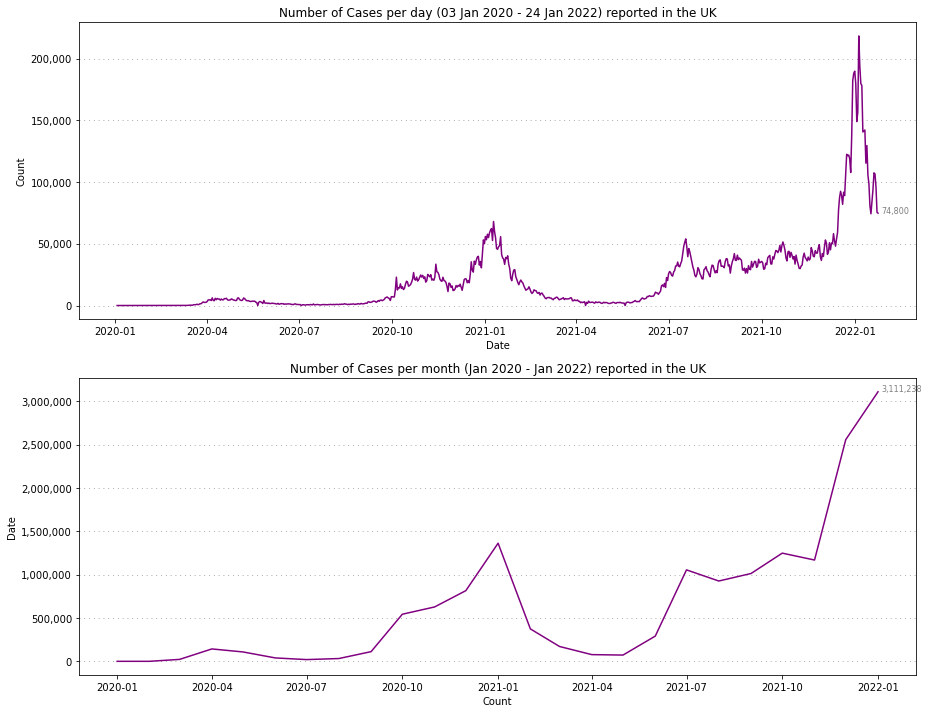

In [5]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,12), nrows=2, ncols=1)
fig.set_facecolor('white')

ax1.plot(data_uk['Date_reported'], data_uk['New_cases'], color='purple')
ax1.set(xlabel='Date', ylabel='Count')
ax1.set_title('Number of Cases per day (' + min_date_uk.strftime('%d %b %Y') + ' - ' + max_date_uk.strftime('%d %b %Y') + ') reported in the UK')
ax1.grid(axis='y', linestyle=':', color='grey', dashes=(1, 5), zorder=0)

# most recent data sample (cases per day plot)
most_recent_entry = data_uk[data_uk['Date_reported'] == data_uk['Date_reported'].max()]
y_co = most_recent_entry['New_cases'].values[0]
x_co = mdates.date2num(most_recent_entry['Date_reported'])
ax1.text(x_co+3, y_co, format(y_co, ','), size=8, alpha=0.5)

ax2.plot(data_uk_month_total['Date_reported'], data_uk_month_total['New_cases'], color='purple')
ax2.set(xlabel='Count', ylabel='Date')
ax2.set_title('Number of Cases per month (' + min_date_uk.strftime('%b %Y') + ' - ' + max_date_uk.strftime('%b %Y') + ') reported in the UK')
ax2.grid(axis='y', linestyle=':', color='grey', dashes=(1, 5), zorder=0)

# format y-axis labels with ','
for ax in [ax1, ax2]:
    y_values = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_values))
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_values])

# most recent data sample (cases per month plot)
most_recent_entry = data_uk_month_total[data_uk_month_total['Date_reported'] == data_uk_month_total['Date_reported'].max()]
y_co = most_recent_entry['New_cases'].values[0]
x_co = mdates.date2num(most_recent_entry['Date_reported'])
plt.text(x_co+3, y_co, format(y_co, ','), size=8, alpha=0.5)

plt.show()

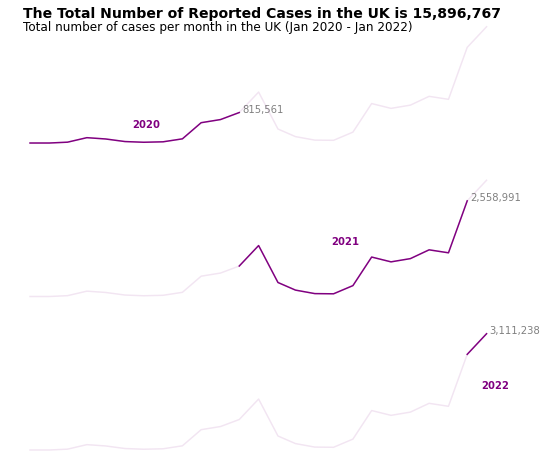

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9,8), nrows=3, ncols=1)
fig.set_facecolor('white')
for ax in [ax1, ax2, ax3]:
    ax.plot(data_uk_month_total['Date_reported'], data_uk_month_total['New_cases'], color='purple', alpha=0.1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(bottom=0, left=0)
    for location in ['left', 'right', 'top', 'bottom']:
        ax.spines[location].set_visible(False)

# title and subtitle
ax1.text(18250, 3350000, 'The Total Number of Reported Cases in the UK is ' + format(data_uk['New_cases'].sum(), ','), size=14, weight='bold')
ax1.text(18250, 3000000, 'Total number of cases per month in the UK (' + min_date_uk.strftime('%b %Y') + ' - ' + max_date_uk.strftime('%b %Y') + ')', size=12)

# coordinates for each years peak (dictionary)
year_peak_coordinates = {}
for year in data_uk_month_total['Date_reported'].dt.year.unique().tolist():
    peak = data_uk_month_total[data_uk_month_total['Date_reported'].dt.year == year]['New_cases'].max()
    date = data_uk_month_total[data_uk_month_total['New_cases'] == peak]['Date_reported']
    value = format(round(peak, 2), ',')
    y = peak
    x = mdates.date2num(date)+5  # convert datetime object to number for x-coordinate
    year_peak_coordinates[year] = (x, y, value)

# plots
ax1.plot(data_uk_month_total['Date_reported'][0:12], data_uk_month_total['New_cases'][0:12], color='purple')
ax1.text(18425, 400000, '2020', color='purple', weight='bold')
ax1.text(year_peak_coordinates[2020][0], year_peak_coordinates[2020][1], year_peak_coordinates[2020][2], alpha=0.5)

ax2.plot(data_uk_month_total['Date_reported'][11:24], data_uk_month_total['New_cases'][11:24], color='purple')
ax2.text(18745, 1400000, '2021', color='purple', weight='bold')
ax2.text(year_peak_coordinates[2021][0], year_peak_coordinates[2021][1], year_peak_coordinates[2021][2], alpha=0.5)

ax3.plot(data_uk_month_total['Date_reported'][23:25], data_uk_month_total['New_cases'][23:25], color='purple')
ax3.text(18985, 1650000, '2022', color='purple', weight='bold')
ax3.text(year_peak_coordinates[2022][0], year_peak_coordinates[2022][1], year_peak_coordinates[2022][2], alpha=0.5)
plt.show()

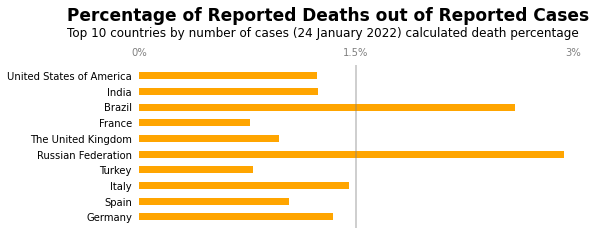

In [7]:
# create dataframe showing the total percentage of deaths for total number of cases in each country
data_country_totals = pd.DataFrame(data.groupby('Country').sum()[['New_cases', 'New_deaths']])
data_country_totals.rename({'New_cases':'total_cases', 'New_deaths':'total_deaths'}, axis=1, inplace=True)
data_country_totals.reset_index(level=0, inplace=True)
data_country_totals['death_percentage'] = round((data_country_totals['total_deaths'] / data_country_totals['total_cases'])*100, 2)

# get top 10 countries for cases and find death percentage
top_10_countries_cases_percent = data_country_totals[data_country_totals['Country'].isin(top_10_countries_cases['Country'].tolist())]

# plot
fig, ax = plt.subplots(figsize=(8,3))
fig.set_facecolor('white')
ax.barh(top_10_countries_cases_percent.sort_values('total_cases')['Country'], 
        top_10_countries_cases_percent.sort_values('total_cases')['death_percentage'], 
        height=0.45, color='orange')
ax.xaxis.tick_top()  # move x-axis to the top
ax.tick_params(top=False, left=False)  # remove ticks
ax.tick_params(axis='x', colors='grey')  # change colour of xtick labels
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)   
highest_death_percent = round(top_10_countries_cases_percent['death_percentage'].max())  # find highest value for x-ticks
ax.set_xticks([0, highest_death_percent/2, highest_death_percent])  # set xtick values
ax.set_xticklabels(['0%', str(highest_death_percent/2)+'%', str(highest_death_percent)+'%'])  # format xtick labels
ax.axvline(x=highest_death_percent/2, c='grey', alpha=0.5)  # add vertical line

# title and subtitle
ax.text(x=-0.5, y=12.5, s='Percentage of Reported Deaths out of Reported Cases', weight='bold', size=17)
ax.text(x=-0.5, y=11.5, s='Top 10 countries by number of cases (' + data['Date_reported'].max().strftime('%d %B %Y') + ') calculated death percentage', size=12)

plt.show()

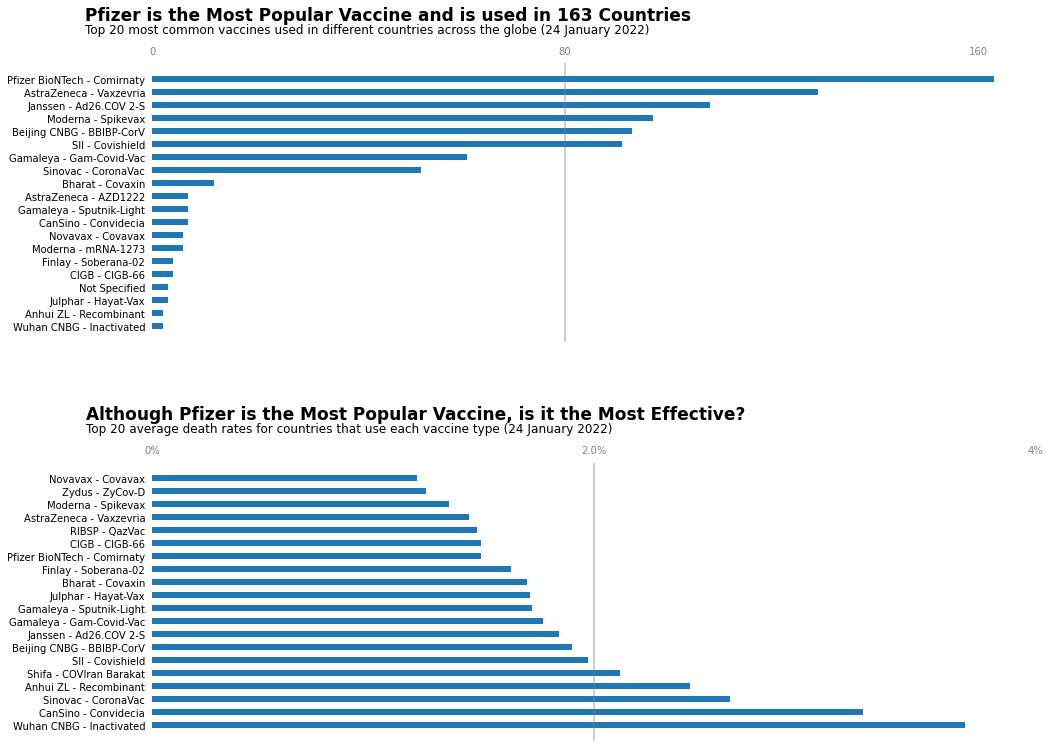

In [8]:
# read vaccination dataset
download_url_data('https://covid19.who.int/who-data/vaccination-data.csv')
vaccine_data = pd.read_csv('data/vaccination-data.csv')

# convert 'DATE_UPDATED' column to datetime object types
vaccine_data['DATE_UPDATED'] = pd.to_datetime(vaccine_data['DATE_UPDATED'])

# create dataframe of vaccine count to show popularity
vaccines_dict = {}
for row in vaccine_data['VACCINES_USED'].fillna('Not Specified'):
    vaccines = row.split(',')
    for vaccine in vaccines:
        vaccine = vaccine.lstrip()
        if vaccine in vaccines_dict:
            vaccines_dict[vaccine] += 1
        else:
            vaccines_dict[vaccine] = 1
vaccines_count_top20 = pd.DataFrame(vaccines_dict.items(), columns=['vaccine', 'count']).sort_values('count', ascending=False).head(20)

# plot1
fig, (ax1, ax2) = plt.subplots(figsize=(13,10), nrows=2, ncols=1)
fig.set_facecolor('white')
fig.tight_layout(h_pad=10)
for ax in [ax1, ax2]:
    ax.xaxis.tick_top()  # move x-axis to the top
    ax.tick_params(top=False, left=False)  # remove ticks
    ax.tick_params(axis='x', colors='grey')  # change colour of xtick labels
    for location in ['left', 'right', 'top', 'bottom']:
        ax.spines[location].set_visible(False)

ax1.barh(vaccines_count_top20.sort_values('count')['vaccine'], vaccines_count_top20.sort_values('count')['count'], 
         height=0.45)
highest_vaccine_count = round(vaccines_count_top20['count'].max(), -1)  # find highest value for x-ticks
ax1.set_xticks([0, highest_vaccine_count/2, highest_vaccine_count])  # set xtick values
ax1.axvline(x=highest_vaccine_count/2, c='grey', alpha=0.5)  # add vertical line
most_popular_vaccine = vaccines_count_top20[vaccines_count_top20['count'] == vaccines_count_top20['count'].max()]['vaccine'].values[0].split(' ')[0]
most_popular_vaccine_count = vaccines_count_top20[vaccines_count_top20['count'] == vaccines_count_top20['count'].max()]['count'].values[0]
ax1.text(x=-13, y=23.5, s=most_popular_vaccine + ' is the Most Popular Vaccine and is used in ' + str(most_popular_vaccine_count) + ' Countries', weight='bold', size=17)
ax1.text(x=-13, y=22.5, s='Top 20 most common vaccines used in different countries across the globe (' + vaccine_data['DATE_UPDATED'].max().strftime('%d %B %Y') + ')', size=12)


# add 'death_percentage' column to vaccine dataset
vaccine_data_deaths = vaccine_data.copy()
vaccine_data_deaths['death_rate'] = vaccine_data_deaths['COUNTRY'].map(data_country_totals.set_index('Country')['death_percentage'])

# create a dictionary containing the average death rates for each type of vaccine
vaccine_death_rate_dict = {}
for row in vaccine_data_deaths.dropna().iterrows():
    vaccine = row[1][11].split(',')
    vaccines = []
    for i in vaccine:
        i = i.lstrip()
        vaccines.append(i)
    for vaccine in vaccines:
        if vaccine in vaccine_death_rate_dict:
            rate = vaccine_death_rate_dict[vaccine][0]
            num = vaccine_death_rate_dict[vaccine][1]
            vaccine_death_rate_dict[vaccine] = ((rate+(row[1][-1])), num+1)
        else:
            vaccine_death_rate_dict[vaccine] = (row[1][-1], 1)
            
death_rate_dict = {}
for country in vaccine_death_rate_dict:
    death_rate = vaccine_death_rate_dict[country][0] / vaccine_death_rate_dict[country][1]
    if country not in death_rate_dict:
        death_rate_dict[country] = death_rate
    else:
        pass

# convert dictionary to dataframe for plot
vaccine_death_rates = pd.DataFrame(death_rate_dict.items(), columns=['vaccine', 'avg_death_rate']).sort_values('avg_death_rate', ascending=False).tail(20)

# plot2
ax2.barh(vaccine_death_rates['vaccine'], vaccine_death_rates['avg_death_rate'], height=0.45)
highest_death_rate = round(vaccine_death_rates['avg_death_rate'].max())  # find highest value for x-ticks
ax2.set_xticks([0, highest_death_rate/2, highest_death_rate])  # set xtick values
ax2.set_xticklabels(['0%', str(highest_death_rate/2)+'%', str(highest_death_rate)+'%'])  # change xtick labels
ax2.axvline(x=highest_death_rate/2, c='grey', alpha=0.5)  # add vertical line
ax2.text(x=-0.3, y=23.5, s='Although ' + most_popular_vaccine + ' is the Most Popular Vaccine, is it the Most Effective?', weight='bold', size=17)
ax2.text(x=-0.3, y=22.5, s='Top 20 average death rates for countries that use each vaccine type (' + vaccine_data['DATE_UPDATED'].max().strftime('%d %B %Y') + ')', size=12)

plt.show()

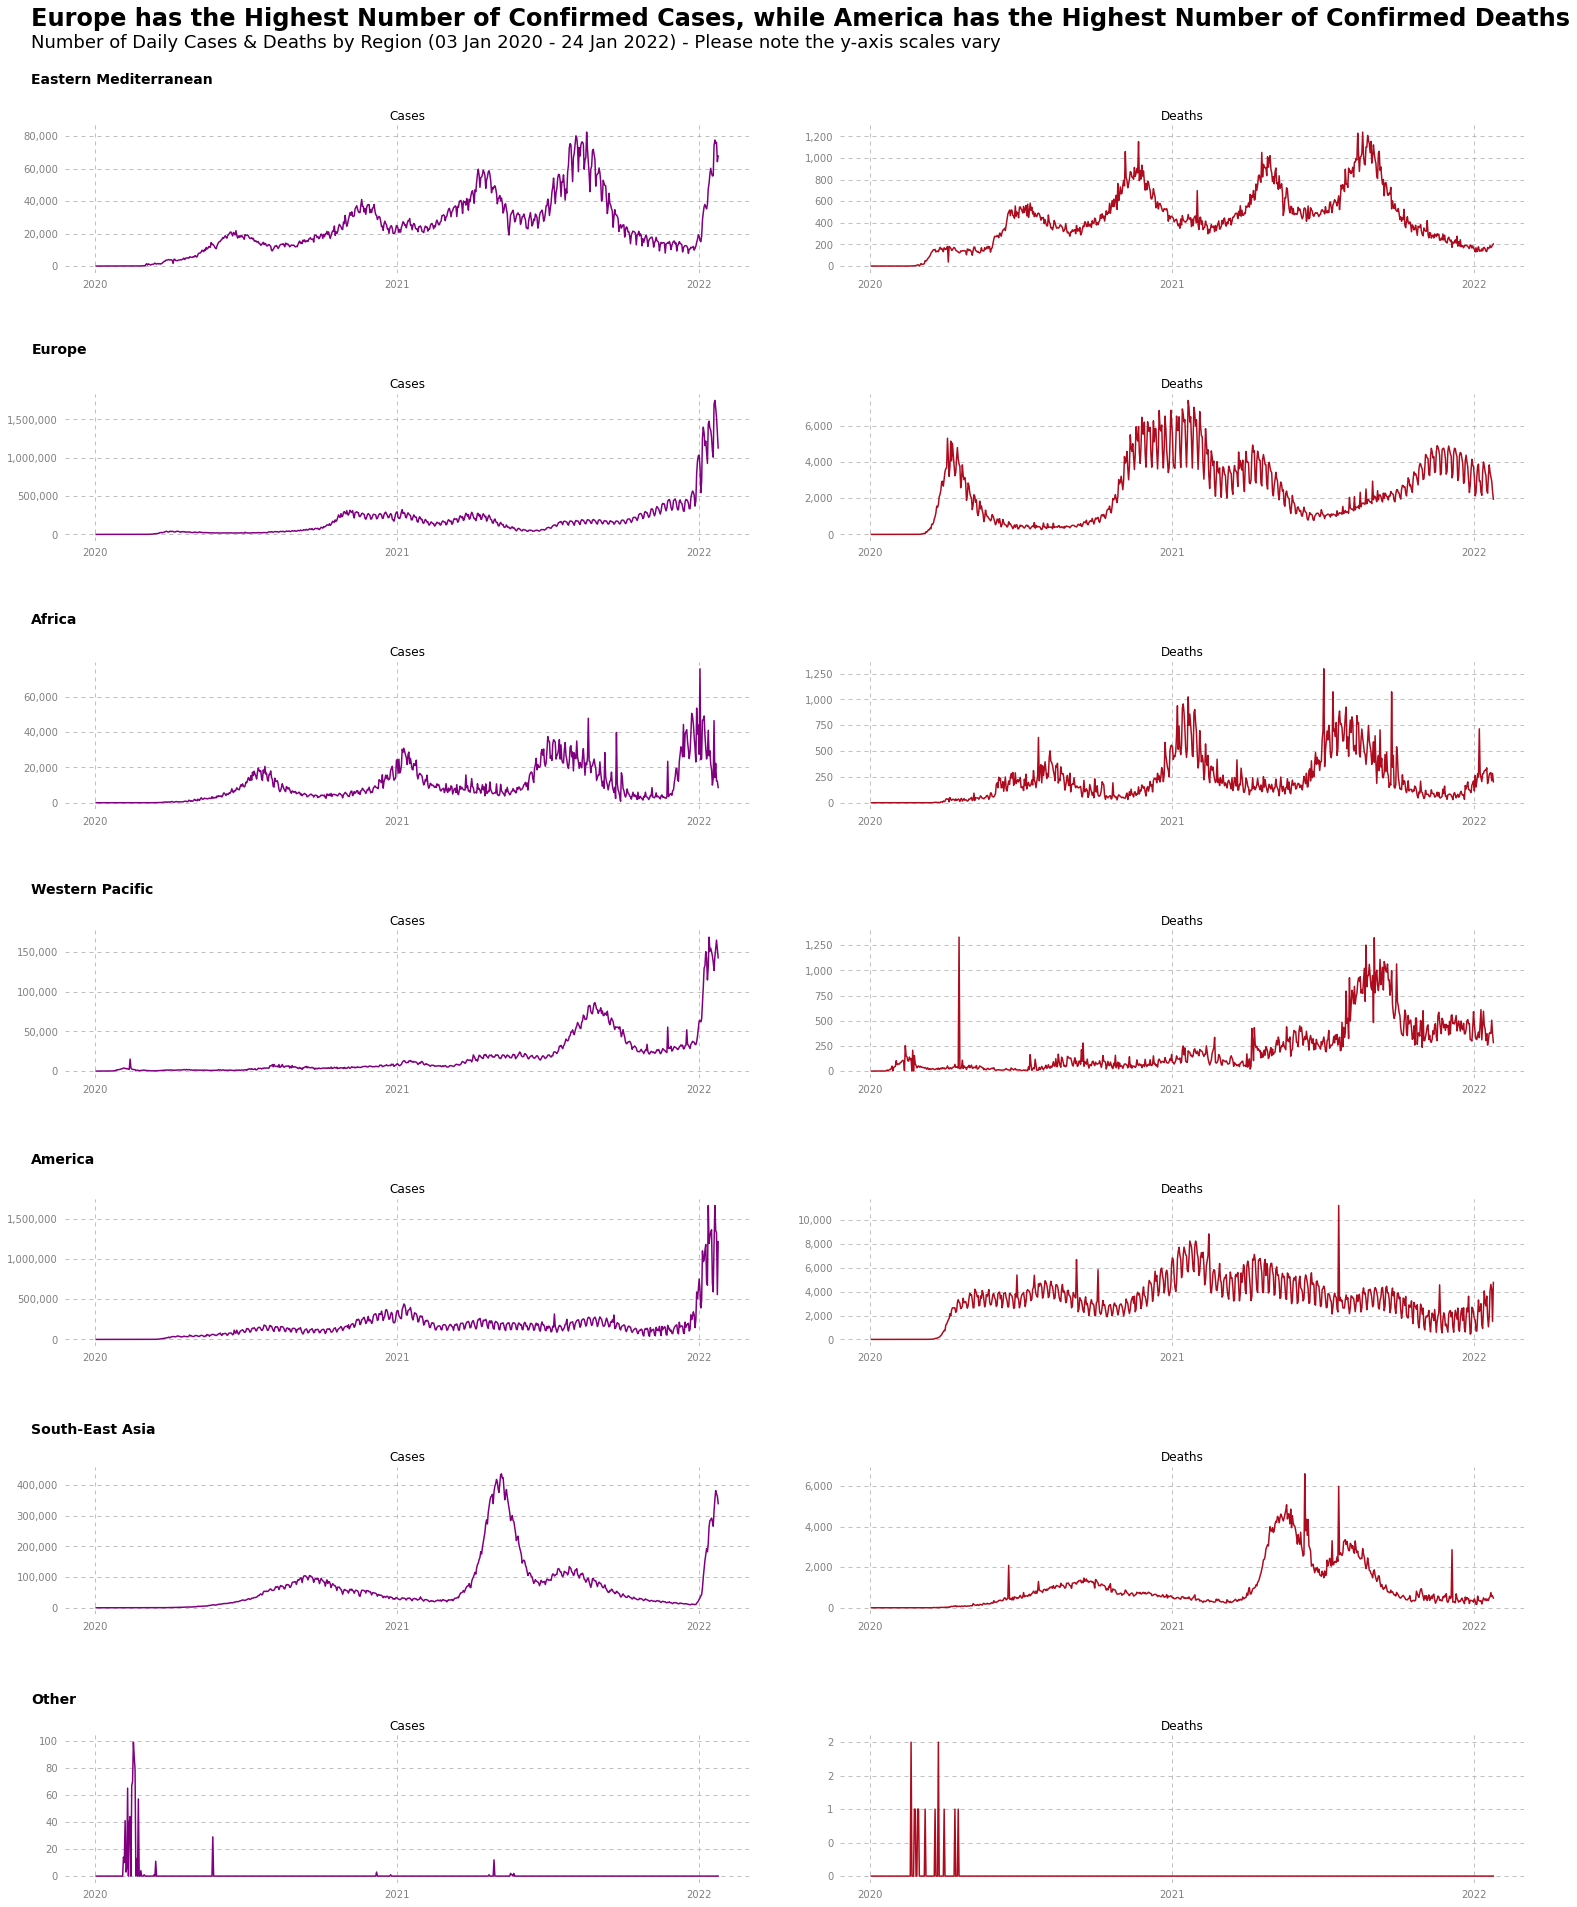

In [9]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10), (ax11,ax12), (ax13,ax14)) = plt.subplots(figsize=(21,25), nrows=7, ncols=2)
fig.set_facecolor('white')
fig.tight_layout(w_pad=6, h_pad=10)

# cases by region plot
for ax, region in zip([ax1, ax3, ax5, ax7, ax9, ax11, ax13], data['WHO_region'].unique().tolist()):
    df = data[data['WHO_region'] == region].groupby('Date_reported').sum()['New_cases'].reset_index()  # group data by region
    ax.plot(df['Date_reported'], df['New_cases'], color='purple')  # plot
    ax.set_title('Cases')  # titles
    ax.tick_params(bottom=False, left=False, colors='grey')  # remove ticks and change tick-labels to grey
    ax.grid(axis='both', linestyle=':', dashes=(5,5))  # add grid
    for location in ['top', 'bottom', 'left', 'right']:  # remove spines
        ax.spines[location].set_visible(False)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))  # set x-ticks to yearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # change format of x-tick dates
    ax.ticklabel_format(axis='y', style='plain')  # show true values on y-axis
    
    # format y-axis labels with ','
    y_values = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_values))
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_values])


# deaths by region plot
for ax, region in zip([ax2, ax4, ax6, ax8, ax10, ax12, ax14], data['WHO_region'].unique().tolist()):
    df = data[data['WHO_region'] == region].groupby('Date_reported').sum()['New_deaths'].reset_index()  # group data by region
    ax.plot(df['Date_reported'], df['New_deaths'], color='#af0b1e')  # plot
    ax.set_title('Deaths')  # titles
    ax.tick_params(bottom=False, left=False, colors='grey')  # remove ticks and change tick-labels to grey
    ax.grid(axis='both', linestyle=':', dashes=(5,5))  # add grid
    for location in ['top', 'bottom', 'left', 'right']:  # remove spines
        ax.spines[location].set_visible(False)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))  # set x-ticks to yearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # change format of x-tick dates
    ax.ticklabel_format(axis='y', style='plain')  # show true values on y-axis
    
    # format y-axis labels with ','
    y_values = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_values))
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_values])

fig.text(0, 1.047, 'Europe has the Highest Number of Confirmed Cases, while America has the Highest Number of Confirmed Deaths', weight='bold', size=24)
fig.text(0, 1.035, 'Number of Daily Cases & Deaths by Region (' + data['Date_reported'].min().strftime('%d %b %Y') + data['Date_reported'].max().strftime(' - %d %b %Y) - Please note the y-axis scales vary'), size=18)

# titles
y = 1.015
for title in ['Eastern Mediterranean', 'Europe', 'Africa', 'Western Pacific', 'America', 'South-East Asia', 'Other']:
    fig.text(0, y, title, weight='bold', size=14)
    y -= 0.15
    
plt.show()